Using seed: 2194162781
Porosity: 0.49923521280288696
Done! - Used the fractal_noise function with the following parameters: "shape": (128, 128)
metadata: {'generator_type': 'PoresPyGenerator/fractal_noise_/128_128', 'size': (128, 128), 'seed': 2194162781, 'porosity': 0.49923521280288696, 'octaves': 6, 'mode': 'simplex', 'gain': 0.5, 'frequency': 0.04}


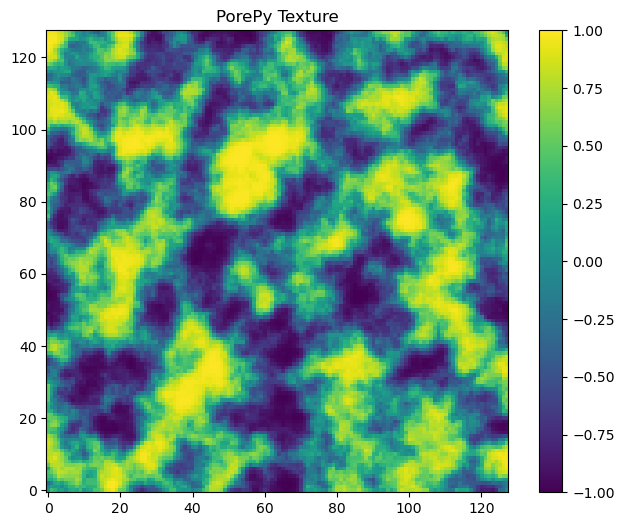

{'generator_type': 'PoresPyGenerator/fractal_noise_/128_128', 'size': (128, 128), 'seed': 2194162781, 'porosity': 0.49923521280288696, 'octaves': 6, 'mode': 'simplex', 'gain': 0.5, 'frequency': 0.04}
All Files saved


In [108]:
import os
import sys
sys.path.insert(0, '../src/1_Spatial_Field_Generators/')

import importlib as oe

import Generators as gen
from Plotting import ImagePlotter
import Classes_Spatial_Analysis as csa

import matplotlib.pylab as plt
import gc
import numpy as np
gc.collect()


oe.reload(gen)

# Usage Example - Generate texture
base_name = "fractal_noise"
generator = gen.PoresPyGenerator(size=(128, 128),name=base_name)
field_data = 2*(generator.generate(frequency=0.04,octaves=6) -0.5) # to scale from [-1,1]
#Plot the result
ImagePlotter.plot(field_data, title='PorePy Texture')
print(generator.metadata)
gc.collect()
generator.two_pt_corr(field_data,filepath=generator.full_path)
generator.save_all()



#% Molar masses (Ca and Ti)
 #% Soil bulk density (g/cm3)
 #% Feedstock (basalt) density (g/cm3)
params_fixed = {'M_Ti' : 47.867, "M_Ca" : 40.078} 

#  % (made up, but reflective of data for Ca and Ti)
soil_params = {'soil_ppm_Ti' : 10000, "soil_ppm_Ca" : 20000, 'rho_soil' : 1.3,
               'field_data_Ca':field_data, 'field_data_Ti':field_data, 
               'num_indices_x' : field_data.shape[0], 'num_indices_y' : field_data.shape[1]}

feed_params = {'feed_ppm_Ti' : 17000, "feed_ppm_Ca" : 80000, 'Xf_init' : 0.01, 'rho_feed' : 2.7,'feed_ppm_Ti_molg_std':0.001,'feed_ppm_Ca_molg_std':0.001} # Xf is the fixed feedstock volume fraction
weathered_params = {'rho_weathered' : 1.3}

soil_params['soil_ppm_Ca_molg'] = soil_params['soil_ppm_Ca'] / (params_fixed['M_Ca'] * 1000) # this should be 1e-6 not 1e-3 ?
soil_params['soil_ppm_Ti_molg'] = soil_params['soil_ppm_Ti'] / (params_fixed['M_Ti'] * 1000) # this should be 1e-6 not 1e-3 ?
feed_params['feed_ppm_Ca_molg'] = feed_params['feed_ppm_Ca'] / (params_fixed['M_Ca'] * 1000) # this should be 1e-6 not 1e-3 ?
feed_params['feed_ppm_Ti_molg'] = feed_params['feed_ppm_Ti'] / (params_fixed['M_Ti'] * 1000) # this should be 1e-6 not 1e-3 ?
weathered_params['soil_ppm_Ca_molg'] = soil_params['soil_ppm_Ca'] / (params_fixed['M_Ca'] * 1000) # this should be 1e-6 not 1e-3 ?
weathered_params['soil_ppm_Ti_molg'] = soil_params['soil_ppm_Ti'] / (params_fixed['M_Ti'] * 1000) # this should be 1e-6 not 1e-3 ?


Model with a feedstock volume fractions of 0.01
Model with params Xwf - 0.002, Xf - 0.008


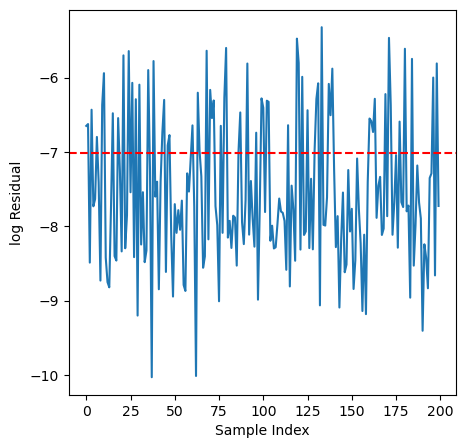

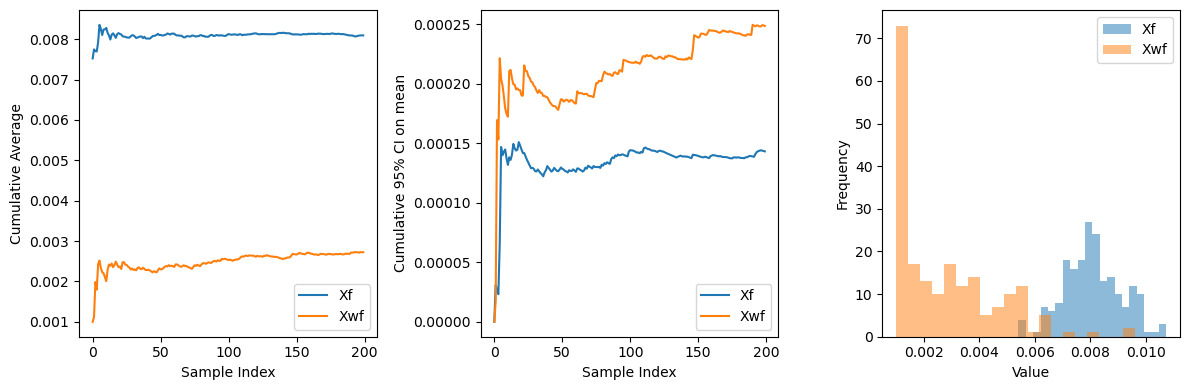

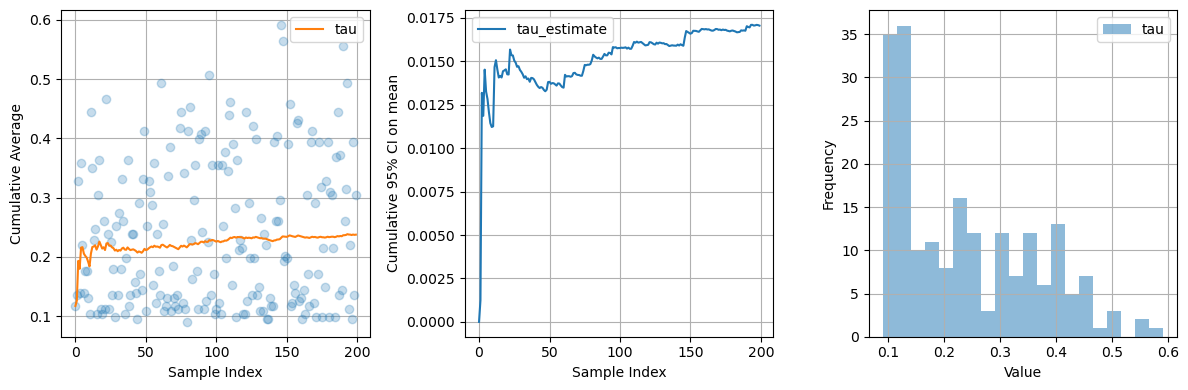

Filtered Results
Filtered number of samples:  200


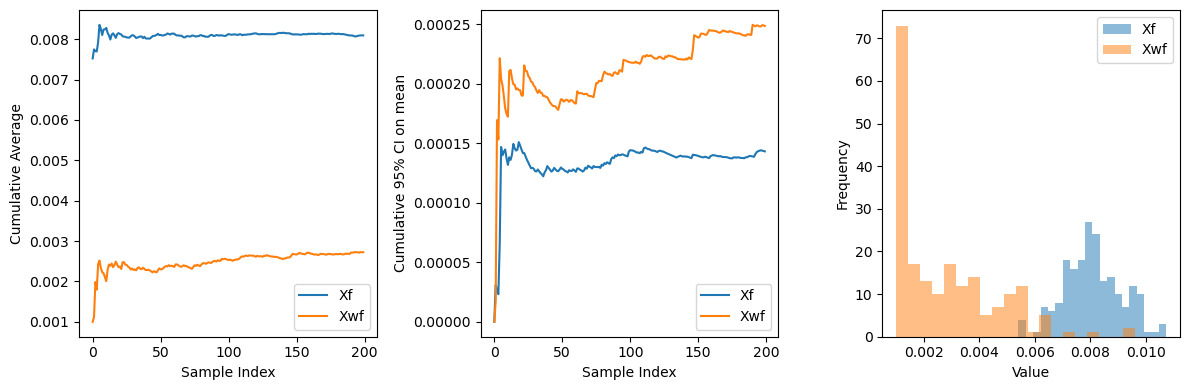

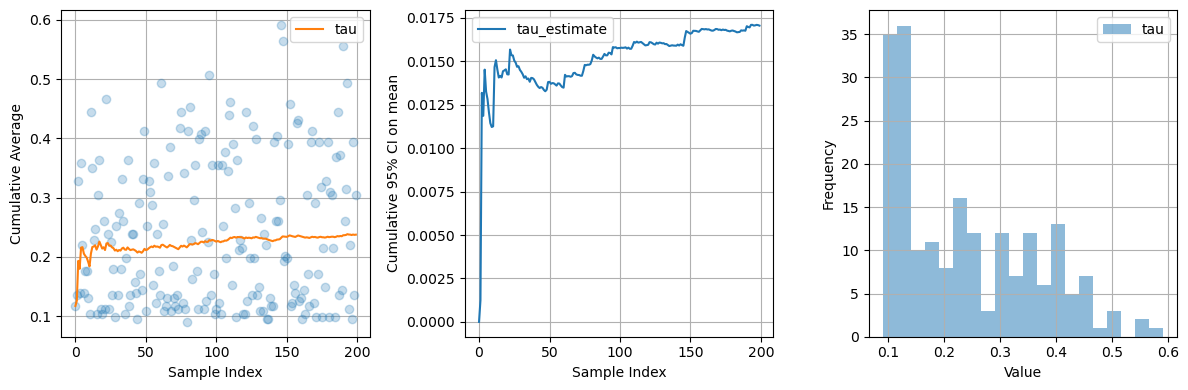

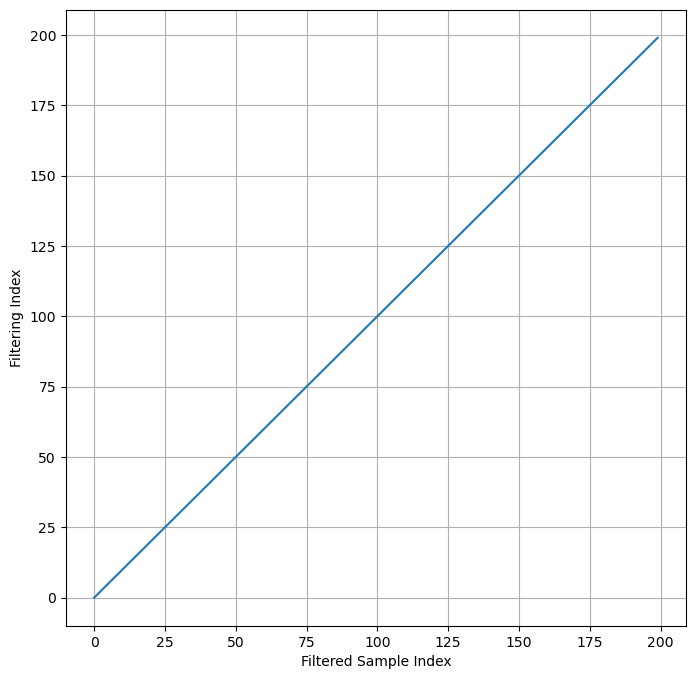

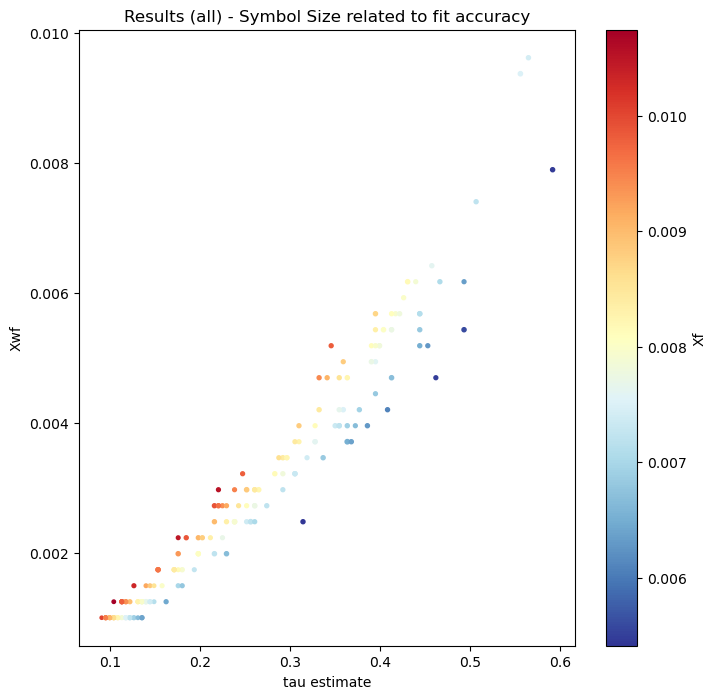

In [102]:
oe.reload(csa)
### Version 1 
#% --- Target Parameters ---
tau_target = 0.2;       #% tau = Xwf / (Xwf + Xf)             
var_Ca = 0.001;         #% Standard error threshold on Ca - 10%
var_Ti = 0.001;         #% Standard error threshold on Ti - 10%
num_samples = 200         # Max number of samples
measurement_error = 0.0  # Error in both Ca and Ti in percentage of the measurement

Xf, Xwf,tau_estimate, cum_avg_Xf, cum_avg_Xwf,cum_avg_tau, cum_std_Xf, cum_std_Xwf,cum_std_tau = \
    csa.base_analysis_single(measurement_error,tau_target,var_Ca,var_Ti,num_samples,soil_params,feed_params,weathered_params,use_std='False',filter_choice='grid')
#filter_choice must be one of ['threshold', 'adaptive_threshold', 'grid', 'grid_conservative']


Model with a feedstock volume fractions of 0.01
Model with params Xwf - 0.001, Xf - 0.009000000000000001


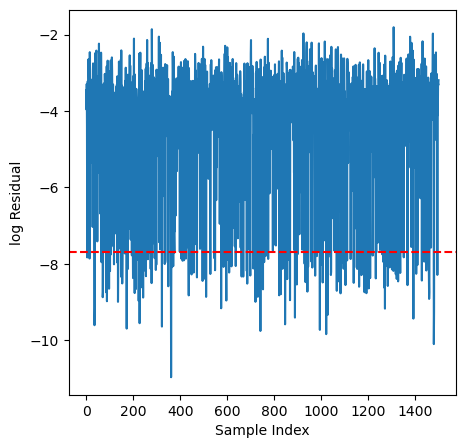

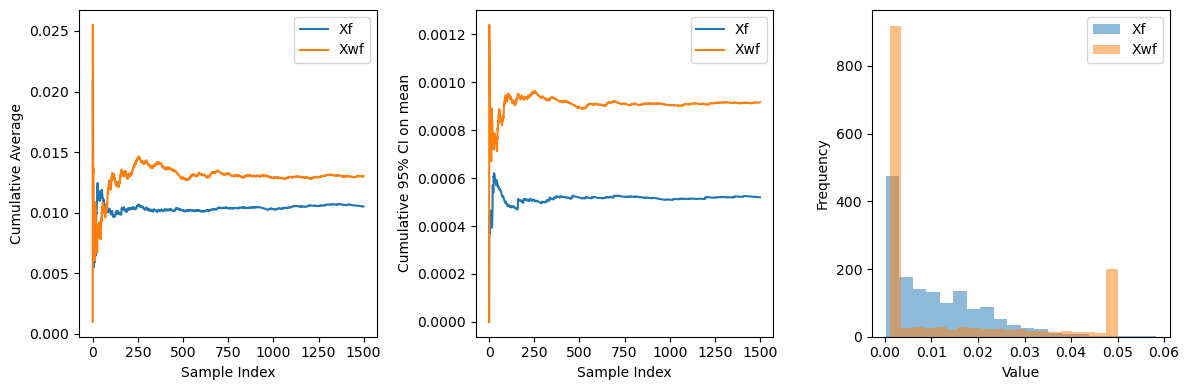

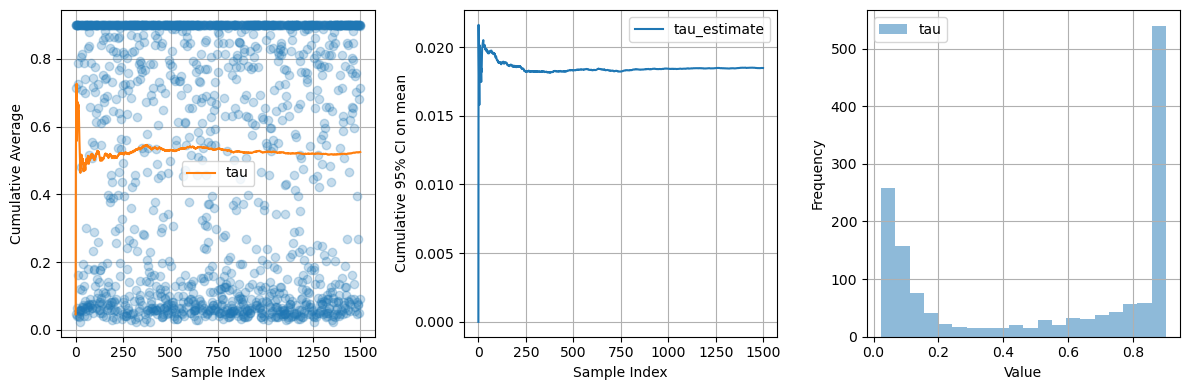

Filtered Results
Filtered number of samples:  273


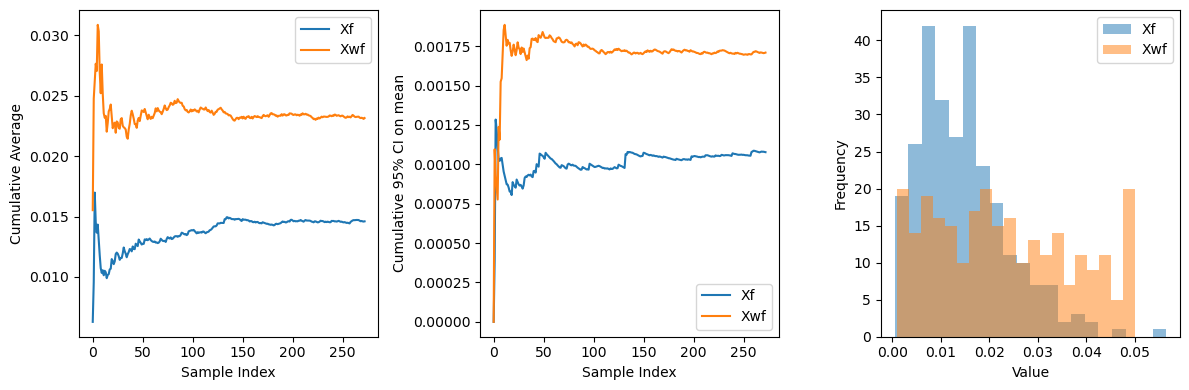

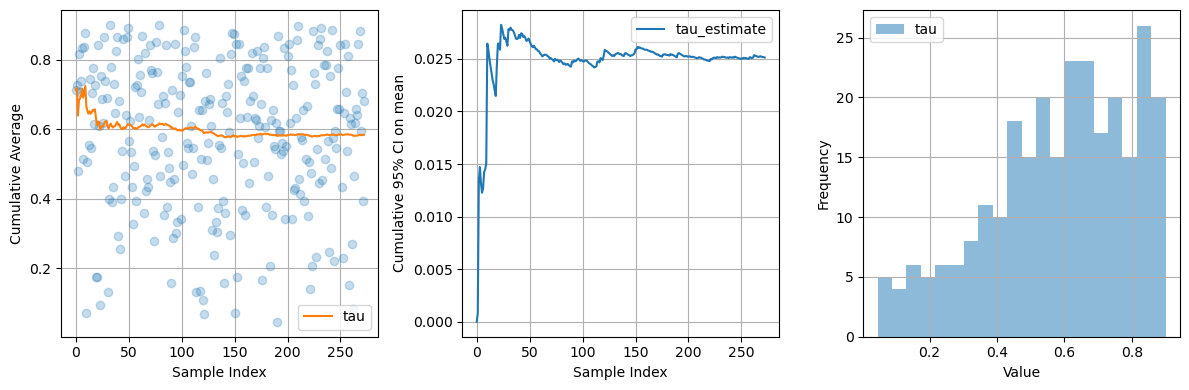

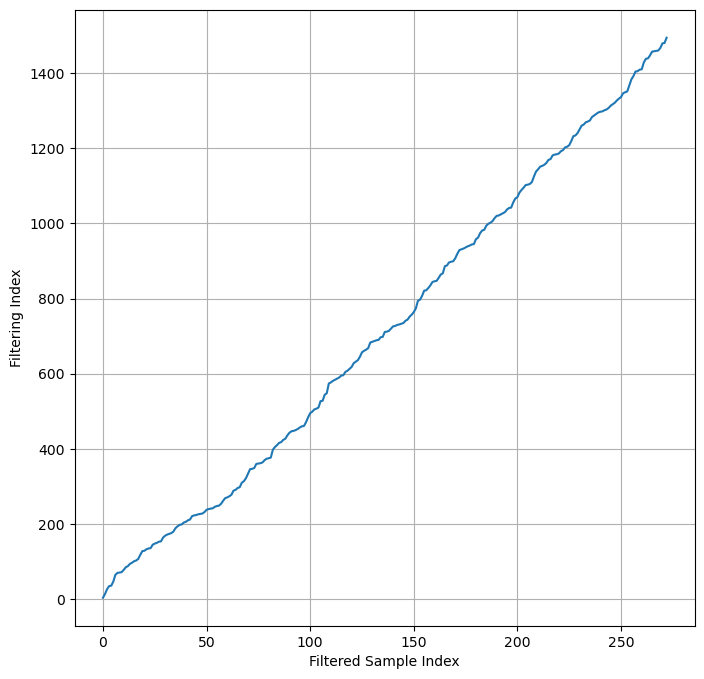

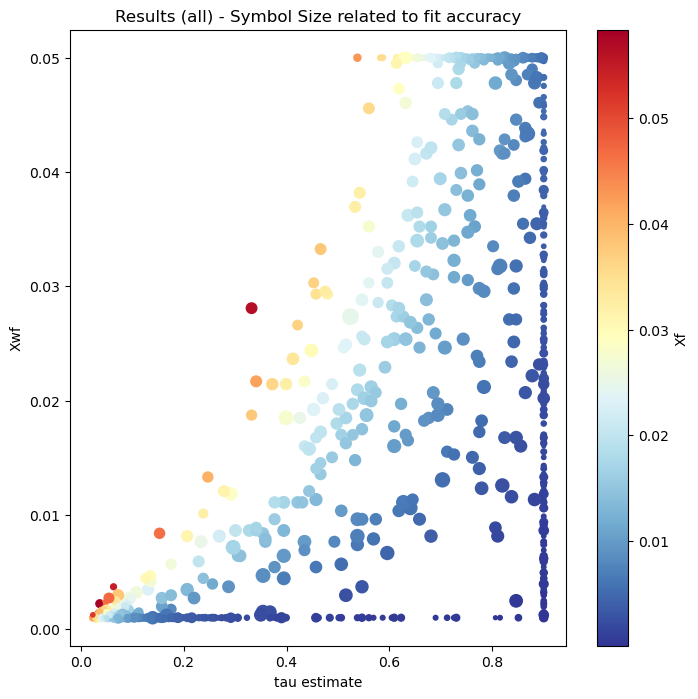

In [140]:
oe.reload(csa)
### Version 2 : batch averaging
num_pooling_per_sample_unit = 10          # Number Physical samples pooled per sample units 
num_actual_samples_per_sample_unit = 3      # Specifies the number of actual sample measurements needed to get a low error (e.g. 5% RMS)
num_sample_units = 500                     # Max number of Sample Units (each is pooled from num_pooling_per_sample_unit samples )
tau_target = 0.1;       #% tau = Xwf / (Xwf + Xf)             
var_Ca = 0.1;         #% Standard error threshold on Ca - 10%
var_Ti = 0.1;         #% Standard error threshold on Ti - 10%
measurement_error = 2.0  # Error in both Ca and Ti in percentage of the measurement


Xf, Xwf,tau_estimate, results,results_filtered = csa.base_analysis_pool(measurement_error,tau_target,var_Ca,var_Ti,soil_params,feed_params,weathered_params,
                                               num_pooling_per_sample_unit,num_sample_units,num_actual_samples_per_sample_unit,use_std='False',filter_choice='threshold')
#filter_choice must be one of ['threshold', 'adaptive_threshold', 'grid', 'grid_conservative'])




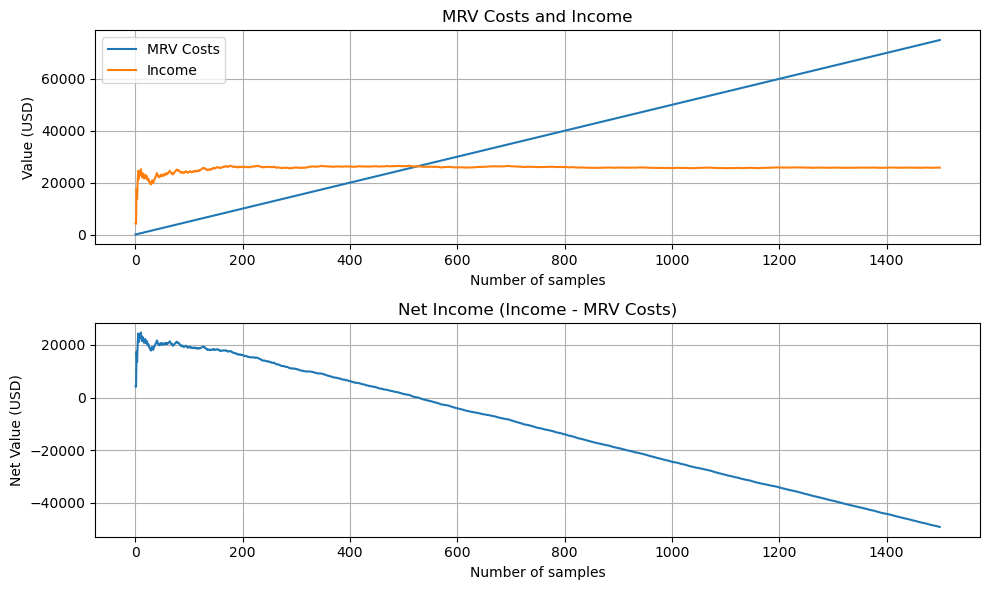

In [136]:
oe.reload(csa)
income, MRV_costs = csa.cost_analysis(results['cum_avg_tau'],results['CI_cum_std_tau'],feed_params,Integrated_application_Tons_basalt= 1000.0,dollar_per_sample=50.0,price_ton=300.0)


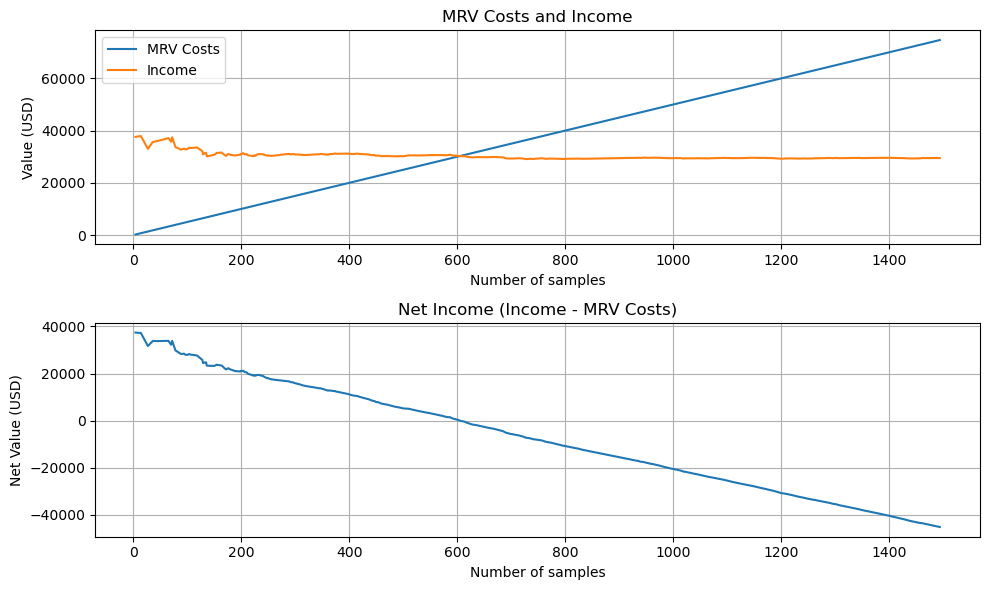

In [144]:
oe.reload(csa)
income, MRV_costs = csa.cost_analysis(results_filtered['cum_avg_tau'],results_filtered['CI_cum_std_tau'],
                                      feed_params,Integrated_application_Tons_basalt= 1000.0,dollar_per_sample=50.0,price_ton=300.0,
                                     filter_indx = results_filtered['filter_indx'])
